In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import multiprocessing
from gensim.models import Word2Vec
from openTSNE import TSNE
from fdict import sfdict
from tqdm import tqdm
from sklearn.decomposition import PCA
from gensim.utils import RULE_DEFAULT, RULE_KEEP
from gensim.models.callbacks import CallbackAny2Vec

In [2]:
ngram_abstracts = np.load("files/ngram_abstracts.npy", mmap_mode="r")
concept_arr = np.unique(np.load("files/overlapping_concepts.npy"))
year_arr = np.load("files/year_arr.npy", mmap_mode="r")
month_arr = np.load("files/month_arr.npy", mmap_mode="r")

In [3]:
def compute_word_count_subset(corpus, subset_words):
    
    for document in tqdm(corpus):
        for word in document:
            if word in subset_words:
                subset_words[word] += 1
    return subset_words

# Compute word count for the subset of words 
word_count_subset = compute_word_count_subset([row.split() for row in ngram_abstracts], {k:0 for k in np.unique(concept_arr)})

def filter_dict_by_occurrence(word_count_dict, n):
    return {word: count for word, count in word_count_dict.items() if count > n}

filtered_concept_dict = np.array(list(filter_dict_by_occurrence(word_count_subset, 10).keys()))

100%|██████████| 157821/157821 [00:00<00:00, 211500.79it/s]


In [4]:
df_ab = pd.DataFrame(data=ngram_abstracts,    # values
                columns=["ab"])  # 1st row as the column names
df_ab["year"] = year_arr
df_ab["month_arr"] = month_arr

In [5]:
df_ab.head()

,ab,year,month_arr
0,supplement paper arxivq bio containing text co...,2007,3
1,outlined possibility extend quantum formalism ...,2007,3
2,quantum_mechanical model diosi feldmann koslof...,2007,4
3,novel way picturing processing_quantum_informa...,2008,5
4,consider single ion confined trap radiation tr...,2007,4


In [6]:
# Define important words
phys_concept_dict = {k:1 for k in concept_arr}

# Custom rule function
def custom_rule(word, count, min_count):
    if word in phys_concept_dict:
        return RULE_KEEP
    else:
        return RULE_DEFAULT

cores = multiprocessing.cpu_count()

# init callback class
class LossLogger(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        
        if self.epoch == 0:
            self.losses.append(loss)
            # print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            self.losses.append(loss- self.loss_previous_step)
            # print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss
loss_logger = LossLogger()

w2v_model = Word2Vec(min_count=5,
                     window=15,
                     vector_size=128,
                     sample=1e-4, 
                     alpha=0.01, 
                     min_alpha= 0.0001, 
                     negative=15,
                     workers=cores-1)

w2v_model.build_vocab([ab.split() for ab in df_ab[df_ab['year'] == int(1994)]["ab"].to_numpy()], trim_rule=custom_rule)
w2v_model.train([ab.split() for ab in df_ab[df_ab['year'] == int(1994)]["ab"].to_numpy()], total_examples=w2v_model.corpus_count, epochs=750, compute_loss=True,callbacks=[loss_logger])
# w2v_model.save("saved_models/model_year_{}.model".format(1994))
for year in tqdm(np.unique(year_arr)[1:]):
   
    ngram_abstracts_year = [ab.split() for ab in df_ab[df_ab['year'] == int(year)]["ab"].to_numpy()]

    w2v_model.build_vocab(ngram_abstracts_year, progress_per=10000,update=True, trim_rule=custom_rule)
    w2v_model.train(ngram_abstracts_year, total_examples=w2v_model.corpus_count, epochs=750, compute_loss=True,callbacks=[loss_logger])
    # w2v_model.save("saved_models/model_year_{}.model".format(year))


100%|██████████| 30/30 [53:57<00:00, 107.93s/it]


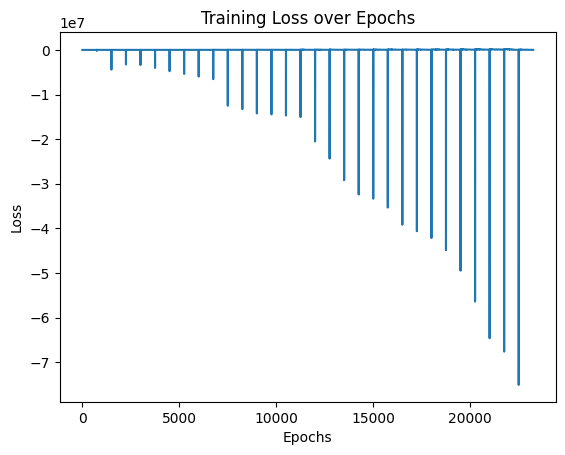

In [7]:
# Plot the training loss
plt.plot(loss_logger.losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


First pass: Find all occurances of concepts individually & save them in a sfdict format.

In [8]:
c_dict = {}
cnt_0 = 0 
cnt_1 = 0
for year in tqdm(np.unique(year_arr)):
        
    loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

    for c in filtered_concept_dict:
        if c not in c_dict:
            c_dict[c] = {}

        if year in c_dict[c]:
            continue 
        else:

            try:
                vec_enc = loaded_w2v.wv.get_vector(c)
                c_dict[c][year] =  vec_enc
                cnt_0 +=1
                
            except: 
                cnt_1+=1
                pass
cnt_1,cnt_0

100%|██████████| 31/31 [00:04<00:00,  7.24it/s]


(130107, 265763)

In [9]:
# c_sfdict = sfdict(c_dict, filename='files/concept_year_dict.db') 
# c_sfdict.sync()  # synchronize all changes back to disk
# c_sfdict.close()  # should always close a db

Second pass: Fill in empty entries: 

1994: empty 1995: empty 1996: encoding, then use same value as 1996 

1996: encoding_0 1997: empty 1998: encoding_1 use same value as 1998, i.e. always from right to left 

In [10]:
len_arr = []
len_new_arr = []
concept_inx_arr = []


for c in tqdm(filtered_concept_dict):
   
    l = len(c_dict[c])
    len_arr.append(l)
    
    if l > 0:
        concept_inx_arr.append(c)
        for success_inx, success_year in enumerate(np.unique(year_arr)): 
            if success_year in c_dict[c]:
                break
            
        for inx, year in enumerate(np.unique(year_arr)[:success_inx]): 
            if year not in c_dict[c]:
                c_dict[c][year] = c_dict[c][success_year]
            else:
                pass

    len_new_arr.append(len(c_dict[c]))
concept_inx_arr = np.array(concept_inx_arr)

100%|██████████| 12770/12770 [00:10<00:00, 1231.05it/s]


In [11]:
len(c_dict[c][year])

128

In [12]:
# c_dict["ac_stark_shift"].keys()

# def filter_dict_by_keys(input_dict, allowed_keys):
#     # Create a new dictionary to store filtered key-value pairs
#     filtered_dict = {}
    
#     # Iterate over the items in the input dictionary
#     for key, value in input_dict.items():
#         # Check if the current key is in the list of allowed keys
#         if key in allowed_keys:
#             # If yes, add the key-value pair to the filtered dictionary
#             filtered_dict[key] = value
    
#     return filtered_dict

In [13]:
c_sfdict = sfdict(c_dict, filename='files/concept_year_dict_filled_1.db') 
c_sfdict.sync()  # synchronize all changes back to disk
c_sfdict.close()  # should always close a db

In [14]:
np.unique(len_new_arr,return_counts=True)

(array([ 0, 31]), array([  402, 12368]))

In [15]:
stop

NameError: name 'stop' is not defined

In [ ]:
# takes about 60 mins
# for year in tqdm(np.unique(year_arr)):
        
#     c_dict = sfdict(filename='files/concept_year_dict_new.db')    
#     loaded_w2v = Word2Vec.load("saved_models/model_year_{}.model".format(year))

#     for c in concept_arr:
#         if c not in c_dict:
#             c_dict[c] = {}

#         if year in c_dict[c]:
#             continue 
#         else:

#             try:
#                 vec_enc = loaded_w2v.wv.get_vector(c)
#                 c_dict[c][year] =  vec_enc
#             except: 
#                 pass

# # takes about 12 mins
# len_arr = []
# len_new_arr = []
# concept_inx_arr = []

# c_dict = sfdict(filename='files/concept_year_dict_new.db')
# for c in tqdm(concept_arr):
   
#     l = len(c_dict[c])
#     len_arr.append(l)
    
#     if l > 0:
#         concept_inx_arr.append(c)
#         for success_inx, success_year in enumerate(np.unique(year_arr)): 
#             if success_year in c_dict[c]:
#                 break
            
#         for inx, year in enumerate(np.unique(year_arr)[:success_inx]): 
#             if year not in c_dict[c]:
#                 c_dict[c][year] = c_dict[c][success_year]
#             else:
#                 pass

#     len_new_arr.append(len(c_dict[c]))
# concept_inx_arr = np.array(concept_inx_arr)
# c_dict.sync()  # synchronize all changes back to disk
# c_dict.close()  # should always close a db

# # check which concepts worked out

# len_new_arr = []


# c_dict = sfdict(filename='files/concept_year_dict.db')
# for c in tqdm(concept_arr):
   
#     l = len(c_dict[c])
#     if l > 0:
        
#         len_new_arr.append(len(c_dict[c]))
    
# c_dict.close()  # should always close a db

Text(0.5, 1.0, 'power_series_expansion vs ac_stark_effect')

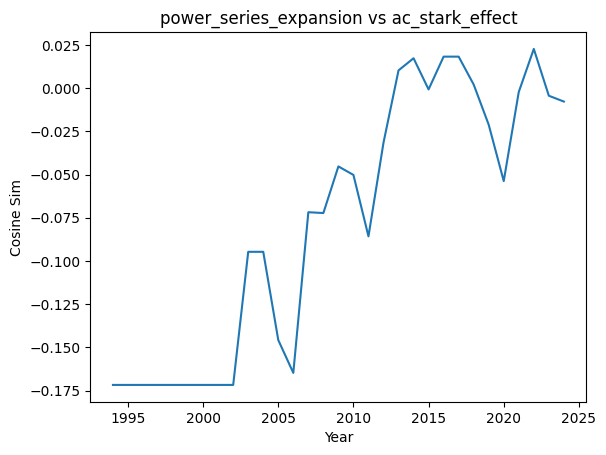

In [ ]:

found = False
a_arr = []
while not found:
    c1=np.random.choice(concept_inx_arr)
    c2=np.random.choice(concept_inx_arr)

    zx_d = c_dict[c1]
    su_d = c_dict[c2]

    track_vec_bell_inequality = np.array([zx_d[i] for i in np.unique(year_arr)])
    track_vec_schroding_equation = np.array([su_d[i] for i in np.unique(year_arr)])

    def similarity_cosine(vec1, vec2):
        cosine_similarity = np.dot(vec1, vec2)/(np.linalg.norm(vec1)* np.linalg.norm(vec2))
        return cosine_similarity

    a = [similarity_cosine(v1, v2) for (v1,v2) in zip(track_vec_bell_inequality,track_vec_schroding_equation)]

    a_arr .append(a)
    if (a[-1]-a[0])<0.3:
        found = True 
        
plt.plot(np.unique(year_arr),a)
plt.ylabel("Cosine Sim")
plt.xlabel("Year")
plt.title(c1 + " vs "+c2)

In [ ]:
# import heapq


# class TopNegativeValuesTotal:
#     def __init__(self):
#         self.heap = []
#         self.size = 100

#     def add_value(self, value, string1, string2):
#         if len(self.heap) < self.size:
#             heapq.heappush(self.heap, [-value, string1, string2])  # Negate the value to make it comparable for a min heap
#         else:
#             min_val = self.heap[0][0]
#             if -value > min_val:  # Negate the value to compare with the minimum value in the heap
#                 heapq.heapreplace(self.heap, [-value, string1, string2])  # Negate the value to make it comparable for a min heap

#     def get_top_values(self):
#         return sorted([[-x[0], x[1], x[2]] for x in self.heap], key=lambda x: x[0])  # Negate the values back to positive
    
# class TopNegativeValuesRelative:
#     def __init__(self):
#         self.heap = []
#         self.size = 100

#     def add_value(self, value, string1, string2):
#         if len(self.heap) < self.size:
#             heapq.heappush(self.heap, [-value, string1, string2])  # Negate the value to make it comparable for a min heap
#         else:
#             min_val = self.heap[0][0]
#             if -value > min_val:  # Negate the value to compare with the minimum value in the heap
#                 heapq.heapreplace(self.heap, [-value, string1, string2])  # Negate the value to make it comparable for a min heap

#     def get_top_values(self):
#         return sorted([[-x[0], x[1], x[2]] for x in self.heap], key=lambda x: x[0])  # Negate the values back to positive

# # Example usage:
# top_values_tracker = TopNegativeValuesTotal()

# # Assuming some process generates values
# process_values = np.random.uniform(low=-1, high=1, size=(10000, 3))

# for value, string1, string2 in process_values:
#     if value < 0:  # Only consider negative values
#         top_values_tracker.add_value(value, string1, string2)

# top_100_negative_values = top_values_tracker.get_top_values()
# print("Top 100 negative values:", top_100_negative_values)


In [ ]:
# import heapq

# class TopNegativeValues:
#     def __init__(self):
#         self.heap = []

#     def add_value(self, value):
#         if len(self.heap) < 100:
#             heapq.heappush(self.heap, value)
#         else:
#             if value < self.heap[0]:
#                 heapq.heappop(self.heap)
#                 heapq.heappush(self.heap, value)

#     def get_top_negative_values(self):
#         return sorted(self.heap)

# # Example usage:
# top_negatives = TopNegativeValues()
# process_values = np.random.uniform(low=-1,high=1,size=10000)

# for value in process_values:
#     top_negatives.add_value(value)

# print("Top 100 negative values:", top_negatives.get_top_negative_values())


In [ ]:
# import heapq

# class TopPositiveValuesTotal:
#     def __init__(self):
#         self.heap = []
#         self.size = 100

#     def add_value(self, value, string1, string2):
        
#         if len(self.heap) < self.size:
#             heapq.heappush(self.heap, [value, string1, string2])
#         else:
#             min_val = self.heap[0][0]
#             if value > min_val:
#                 heapq.heapreplace(self.heap, [value, string1, string2])

#     def get_top_values(self):
#         return sorted(self.heap, key=lambda x: x[0], reverse=True)
    
# class TopPositiveValuesRelative:
#     def __init__(self):
#         self.heap = []
#         self.size = 100

#     def add_value(self, value, string1, string2):
        
#         if len(self.heap) < self.size:
#             heapq.heappush(self.heap, [value, string1, string2])
#         else:
#             min_val = self.heap[0][0]
#             if value > min_val:
#                 heapq.heapreplace(self.heap, [value, string1, string2])

#     def get_top_values(self):
#         return sorted(self.heap, key=lambda x: x[0], reverse=True)

# # Example usage:
# top_values_tracker_relative_pos = TopPositiveValuesRelative()
# top_values_tracker_total_pos = TopPositiveValuesTotal()
# top_values_tracker_relative_neg = TopNegativeValuesRelative()
# top_values_tracker_total_neg = TopNegativeValuesTotal()


# top_values_tracker_relative_pos.add_value(relative_change, c_1, c_2)
# top_values_tracker_total_pos.add_value(distance_change, c_1, c_2)
# top_values_tracker_relative_neg.add_value(relative_change, c_1, c_2)
# top_values_tracker_total_neg.add_value(distance_change, c_1, c_2)




# # Assuming some process generates values
# process_values = np.random.uniform(low=-1,high=1,size=(10000,3))

# for value, string1, string2 in process_values:
#     top_values_tracker.add_value(value, string1, string2)

# top_100_positive_values = top_values_tracker.get_top_values()
# print("Top 100 positive values:", top_100_positive_values)
